In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
#dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}
dict_genres = {'Electronic':0, 'Experimental':1, 'Instrumental':4,'International':5, 'Pop' :6}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 4: 'Instrumental', 5: 'International', 6: 'Pop'}


In [4]:
npzfile = np.load('data/shuffled_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [5]:
y_train_mask = np.in1d(y_train, list(dict_genres.values()))

In [6]:
y_train = y_train[y_train_mask]

In [7]:
y_train = utils.to_categorical(y_train, num_classes=8).astype(int)

In [8]:
y_train_max = np.argmax(y_train, axis=1)
y_train_max[y_train_max == 4] = 2
y_train_max[y_train_max == 5] = 3
y_train_max[y_train_max == 6] = 4

In [9]:
y_train = utils.to_categorical(y_train_max, num_classes=5).astype(int)

In [11]:
X_train = X_train[y_train_mask]

In [12]:
X_train.shape, y_train.shape

((3998, 640, 128), (3998, 5))

In [13]:
npzfile = np.load('data/shuffled_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [14]:
y_valid_mask = np.in1d(y_valid, list(dict_genres.values()))

In [15]:
y_valid = y_valid[y_valid_mask]

In [16]:
y_valid = utils.to_categorical(y_valid, num_classes=8).astype(int)

In [17]:
y_valid_max = np.argmax(y_valid, axis=1)
y_valid_max[y_valid_max == 4] = 2
y_valid_max[y_valid_max == 5] = 3
y_valid_max[y_valid_max == 6] = 4

In [18]:
y_valid = utils.to_categorical(y_valid_max, num_classes=5).astype(int)

In [19]:
X_valid = X_valid[y_valid_mask]

In [20]:
X_valid.shape, y_valid.shape

((500, 640, 128), (500, 5))

## Check by plotting a Spectogram

Instrumental


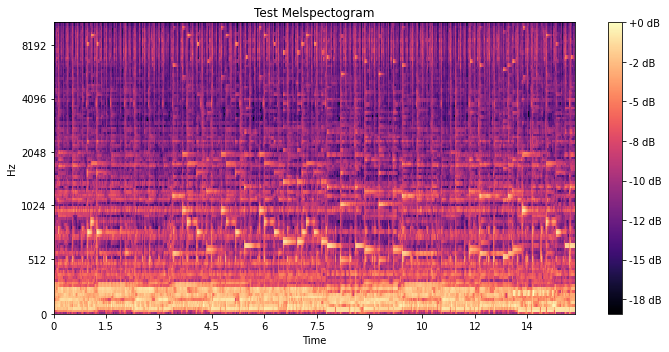

In [21]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [22]:
batch_size = 32
num_classes = 5
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [23]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

BATCH_SIZE = 64
EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [24]:
def train_model(x_train, y_train, x_val, y_val, info = ""):
    n_frames = 640
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/tree_3/model_root_f1_1_1/"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/tree_3/model_root_f1_1_1/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [25]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Building model...
Training...
Epoch 1/30
63/63 [==============================] - 22s 192ms/step - loss: 2.1596 - accuracy: 0.2424 - val_loss: 1.4894 - val_accuracy: 0.3540

Epoch 00001: val_accuracy improved from -inf to 0.35400, saving model to ./models/tree_3/model_root_f1_1_1/folder1\model.h5
Epoch 2/30
63/63 [==============================] - 9s 148ms/step - loss: 1.5156 - accuracy: 0.3347 - val_loss: 1.5207 - val_accuracy: 0.3460

Epoch 00002: val_accuracy did not improve from 0.35400
Epoch 3/30
63/63 [==============================] - 9s 148ms/step - loss: 1.4490 - accuracy: 0.3964 - val_loss: 1.4228 - val_accuracy: 0.3560

Epoch 00003: val_accuracy improved from 0.35400 to 0.35600, saving model to ./models/tree_3/model_root_f1_1_1/folder1\model.h5
Epoch 4/30
63/63 [==============================] - 9s 148ms/step - loss: 1.4177 - accuracy: 0.4122 - val_loss: 1.3295 - val_accuracy: 0.5140

Epoch 00004: val_accuracy improved from 0.35600 to 0.51400, saving model to ./models/tree_3

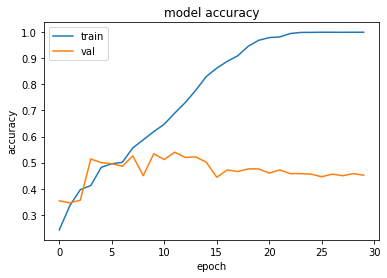

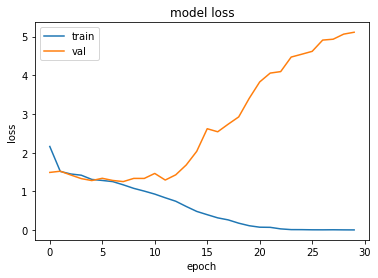

In [26]:
model, history = train_model(X_train, y_train, X_valid, y_valid, "folder{}".format(1))
show_summary_stats(history)